In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


 # **Курсовой проект**

# **Задание**

Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv.
Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

In [2]:
# Подключение библиотек и настройки ноутбука

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib 
import random
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
import seaborn as sns
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

matplotlib.rcParams.update({'font.size': 9})

In [3]:
# Функция для расчёта метрики R2 качества моделей
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print(f'Train R2: {round(r2_score(train_true_values, train_pred_values), 3)},\
            Test R2:{round(r2_score(test_true_values, test_pred_values), 3)}')
    
    check_train = pd.DataFrame({
        "true": train_true_values,
        "pred": train_pred_values.flatten(),
    })

    check_test = pd.DataFrame({
        "true": test_true_values,
        "pred": test_pred_values.flatten(),
    })

    sns.scatterplot(data=check_train, x="pred", y="true", alpha=.5, label="Train")
    sns.scatterplot(data=check_test, x="pred", y="true", alpha=.5, label="Test")

In [4]:
# Пути к файлам
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
SAMPLE_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

# **1. Загрузка данных**

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3**- социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры



In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [9]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [10]:
# Преобразование типов
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# **2. EDA**

**1. Анализ целевого признака**

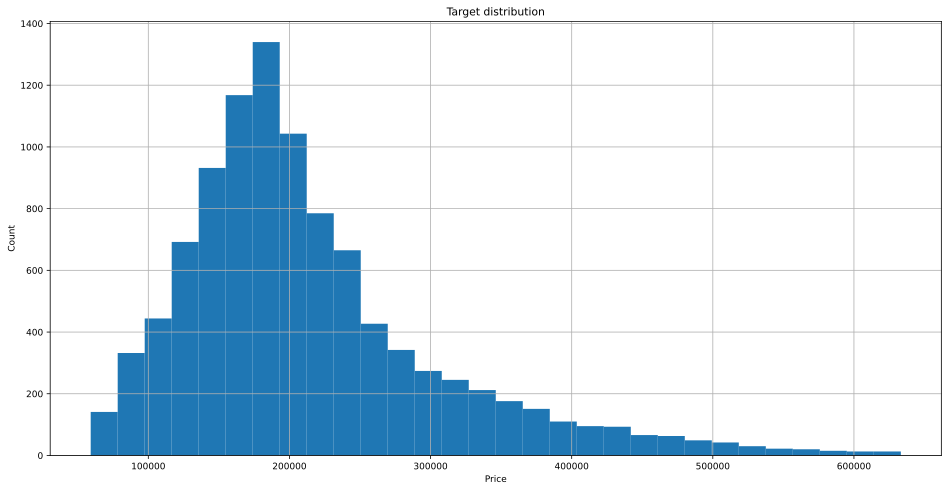

In [11]:
# Построим распределение целевой переменной

plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Гистрограмма показывает, что большинсто квартир стоят в среднем в диапазоне от 160000 до 220000. Выбросов в случае очень дорогих и очень дешёвых квартир не наблюдается. Значения целевой переменной не нуждаются в корректировке

**2. Анализ категориальных признаков**

In [12]:
# Проверим наличие категориальных признаков
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [13]:
# Значения id района
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
209      1
196      1
174      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [14]:
# Значения признаков экологии
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
# Значения признаков для магазинов
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**3. Анализ вещественных признаков**

Rooms

In [17]:
# Медиана и среднее для Rooms
room_mean = train_df['Rooms'].mean()
room_mean

1.8905

In [18]:
room_median = train_df['Rooms'].median()
room_median

2.0

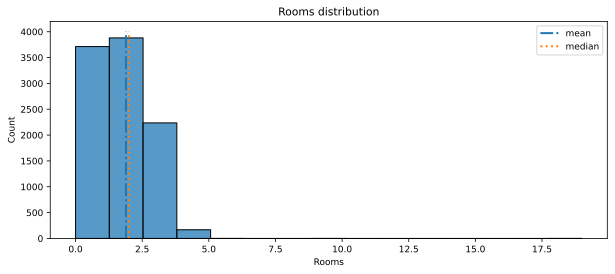

In [19]:
# Построим распределение для признака Rooms
plt.figure(figsize = (10, 4))

sns.histplot(train_df['Rooms'], bins=15)

y = np.linspace(0, 4000, 10)
plt.plot([room_mean] * 10, y, label='mean', linestyle='-.', linewidth=2)
plt.plot([room_median] * 10, y, label='median', linestyle=':', linewidth=2)

plt.title('Rooms distribution')
plt.legend()
plt.show()

Гистограмма показывает, что подавляющее число квартир имеют всего две комнаты. Квартиры с четыремя комнатами и больше встречаются крайне редко

In [20]:
# Количество квартир с конкретным числом комнат
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Обнаружены выбросы по количеству комнат в квартире. 0, 10 и 19 комнат вряд ли возможно, поэтому эти значения нужно будет обработать. В случае, если комнат 0, заменим это значение квантилями 2,5 %, а в случае, если их число 6 или больше - квантилями 97,5 %.

HouseFloor

In [21]:
# Медиана и среднее для HouseFloor
hfloor_mean = train_df['HouseFloor'].mean()
hfloor_mean

12.6094

In [22]:
hfloor_median = train_df['HouseFloor'].median()
hfloor_median

13.0

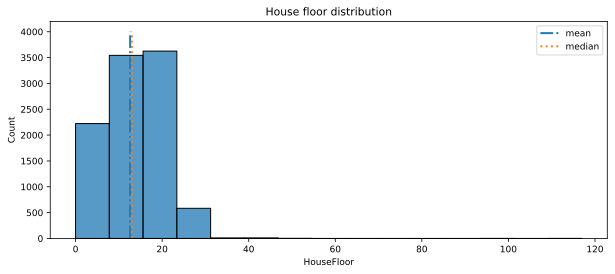

In [23]:
# Построим распределение для этажности домов
plt.figure(figsize = (10, 4))

sns.histplot(train_df['HouseFloor'], bins=15)

y = np.linspace(0, 4000, 10)
plt.plot([hfloor_mean] * 10, y, label='mean', linestyle='-.', linewidth=2)
plt.plot([hfloor_median] * 10, y, label='median', linestyle=':', linewidth=2)

plt.title('House floor distribution')
plt.legend()
plt.show()

В большинстве домов в среднем 13 этажей. Дома в 20 и более этажей встречаются крайне редко

In [24]:
# Все значения HouseFloor
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

В данном признаке также имеются выбросы. Этажность дома выше 95 вряд ли возможна, для этого признака также требуется обработка значений. Если количество этажей равно нулю, то заменим это значение на 1. Если количество этажей в доме больше 95, заменим это значение на моду данного признака. Также необходимо учесть, что этаж квартиры должен быть меньше или равен количеству этажей в доме. 

**Floor**

In [25]:
# Медиана и среднее для HouseFloor
floor_mean = train_df['Floor'].mean()
floor_mean

8.5267

In [26]:
floor_median = train_df['Floor'].median()
floor_median

7.0

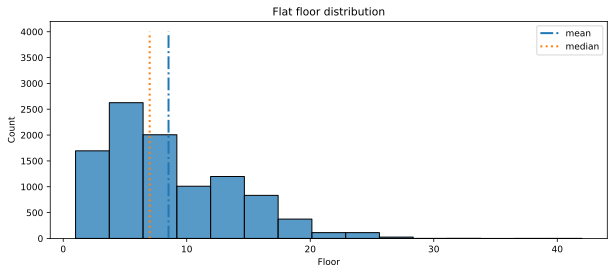

In [27]:
# Построим распределение для этажа квартиры
plt.figure(figsize = (10, 4))

sns.histplot(train_df['Floor'], bins=15)

y = np.linspace(0, 4000, 10)
plt.plot([floor_mean] * 10, y, label='mean', linestyle='-.', linewidth=2)
plt.plot([floor_median] * 10, y, label='median', linestyle=':', linewidth=2)

plt.title('Flat floor distribution')
plt.legend()
plt.show()

Самые популярные этажи с 6 по 10. Квартир, которые располагаются на этажах выше 10 гораздо меньше.Этажи выше 20 наименее популярны

In [28]:
# Все значения Floor
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

Значения данного признака нужно также обработать совместно с HouseFloor. Главное условие: этаж квартиры должен быть меньше или равен этажности дома

**HouseYear**

In [29]:
# Медиана и среднее для HouseYear
year_mean = train_df['HouseYear'].mean()
year_mean

3990.1663

In [30]:
year_median = train_df['HouseYear'].median()
year_median

1977.0

In [31]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

Неадекватные значения (больше текущего года) нужно будет заменить на текущий год

**Square**

In [32]:
# Медиана и среднее для Square
square_mean = train_df['Square'].mean()
square_mean

56.315775197935615

In [33]:
square_median = train_df['Square'].median()
square_median

52.51330992401352

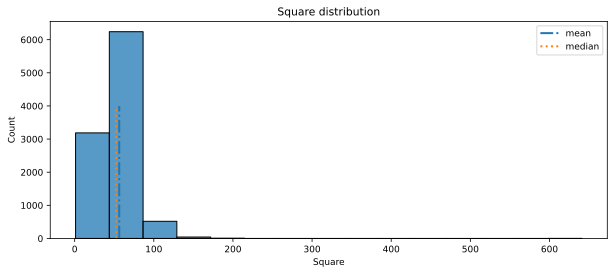

In [34]:
# Построим распределение для площади
plt.figure(figsize = (10, 4))

sns.histplot(train_df['Square'], bins=15)

y = np.linspace(0, 4000, 10)
plt.plot([square_mean] * 10, y, label='mean', linestyle='-.', linewidth=2)
plt.plot([square_median] * 10, y, label='median', linestyle=':', linewidth=2)

plt.title('Square distribution')
plt.legend()
plt.show()

Больше всего квартир имеют площадь около 50 кв.м. Число квартир с площадью больше 100 кв. метров крайне мало

In [35]:
train_df['Square'].sort_values().unique()

array([  1.13685878,   1.98894272,   2.37724759, ..., 409.42518143,
       604.70597195, 641.06519275])

Значения площади меньше 18 кв.м. и больше 120 неадекватны, поэтому эти выбросы также необходимо обработать. Площадь меньше 18 кв. метров заменим на 18, если площадь квартиры больше 600 (возможно лишняя цифра при наборе данных), то разделим её на 10.

> **KitchenSquare**

In [36]:
# Посмотрим значения статистик для площади кухни
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [37]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

Значения площади кухни, которые больше площади квартиры или меньше 4 кв.м, необходимо обработать. Должно выполняться условие: площадь кухни меньше площади квартиры с учётом наличия в квартире дополнительных помещений (например санузла), т.е. вычтем 3 кв. м. Если площадь кухни меньше 4 кв.м., то заменим эти значения на 4. В остальных случаях заменим значения на квантили 

**LifeSquare**

In [38]:
# Постмотри статистики для жилой площади
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [39]:
train_df['LifeSquare'].value_counts()

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64

Жилая площадь должна быть больше площади кухни, но меньше площади квартиры. Если эти условия не выполняются, то необходимо моменять эти значения между собой. Минимальную жилую площадь примем за квантиль 12,5 %.

**Проверка пропущенных значений**

In [40]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Для признаков LifeSquare и Healhcare_1 обнаружено большое число пропусков, которые необходимо обработать

# **3. Обработка выбросов и пропусков**

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""        
        self.medians = None
        self.kitchen_square_quantile = None
        self.rooms_quantile_min = None
        self.rooms_quantile_max = None
        self.house_floor_mode=None
        self.life_square_quantile = None
        self.square_quantile_min = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.rooms_quantile_min = X['Rooms'].quantile(0.025)
        self.rooms_quantile_max = X['Rooms'].quantile(0.975)
        self.house_floor_mode = X['HouseFloor'].mode()[0]
        self.square_quantile_min = X['Square'].quantile(0.025)
        self.life_square_quantile = X['LifeSquare'].quantile(0.125)
                
    # Функция для вычисления жилой площади с учётом дополнительных помещений
    def life_square(self, square, kitchen_square):
        return square - kitchen_square - 3
    
    # Функция для вычисления общей площади с учётом дополнительных помещений
    def square(self, life_square, kitchen_square):
        return life_square + kitchen_square + 3

    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 0), "Rooms"] = 1
        X.loc[(X['Rooms'] >= 6), "Rooms"] = self.medians['Rooms']
        
        # HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[((X['HouseFloor'] == 0) | (X['HouseFloor'] > 95)), 'HouseFloor_outlier'] = 1
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = 1
        X.loc[(X['HouseFloor'] > 95), 'HouseFloor'] = self.medians['HouseFloor']
        
        # Floor
        more_house_floor = X.loc[(X['Floor'] > X['HouseFloor'])].index
        X.loc[more_house_floor, 'Floor'] = X.loc[more_house_floor, 'HouseFloor'].apply(lambda x: random.randint(1,x))

        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # Square
        X.loc[train_df['Square'] < 18, 'Square'] = 18
        cond = train_df['Square'] > 600
        X.loc[cond, 'Square'] = X.loc[cond, 'Square'].apply(lambda x: x/10)

        # KitchenSquare
        cond = ((X['KitchenSquare'] > 30) & ~(X['LifeSquare'].isna()) & ~(X['Square'].isna()))
        square_outliers = X.loc[cond, 'KitchenSquare'].index
        X.loc[square_outliers, 'KitchenSquare'] = X.loc[square_outliers, 'Square'] - X.loc[square_outliers, 'LifeSquare'] - 3
        cond = ((X['KitchenSquare']) > (self.kitchen_square_quantile))
        X.loc[cond, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare'] = 4

        # LifeSquare 
        cond = X['LifeSquare'] > 800
        X.loc[X['LifeSquare'] > 800, 'LifeSquare'] = self.life_square(X.loc[cond, 'Square'], X.loc[cond, 'KitchenSquare'])
        incorrect_lifesquare = X.loc[(X['LifeSquare'] > X['Square']), ['Square', 'LifeSquare']].index
        X.loc[incorrect_lifesquare, ['Square', 'LifeSquare']] = X.loc[incorrect_lifesquare, ['LifeSquare', 'Square']].values
        cond = ((X['Square'] < self.square(X['LifeSquare'], X['KitchenSquare'])) | (X['LifeSquare'].isna()))
        not_correct_lifesquare = X.loc[cond, 'LifeSquare'].index
        X.loc[not_correct_lifesquare, 'LifeSquare'] = X.loc[not_correct_lifesquare,'Square'] - X.loc[not_correct_lifesquare, 'KitchenSquare'] - 3
        X.loc[(X['LifeSquare'] < self.life_square_quantile), 'LifeSquare'] = self.life_square_quantile
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)       
        
       # Пропуски заполним медианами
        X.fillna(self.medians, inplace=True)

        return X


# **4. Генерация новых признаков**

Создадим новые признаки:
* **MedPriceByDistrict** - средняя цена квартиры по району
* **MedPriceBySocial** - средняя цена квартиры по социальным признакам
* **MedPriceByFloor** - средняя цена квартиры по этажу
* **IsDistrictLarge** - признак размера района
* **DistrictSize**


В категориальных признаках сделаем замену значений А и В на 0 и 1 соотвественно

In [42]:
# Класс для генерации новых признаков
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_social = None
        self.med_price_by_health = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Преобразование категориальных признаков
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # District, Rooms
        df = X.copy()
        
        if y is not None:
           df['Price'] = y.values
           self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceByDistrict'})
           self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

           self.med_price_by_social = df.groupby(['Social_1', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceBySocial'})
           self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()

           self.med_price_by_floor = df.groupby(['Rooms', 'Floor'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByFloor'})
           self.med_price_by_floor_median = self.med_price_by_floor['MedPriceByFloor'].median()
            
        # floor, year
        if y is not None:
           self.floor_max = df['Floor'].max()
           self.house_year_max = df['HouseYear'].max()
           df['Price'] = y.values
           df = self.floor_to_cat(df)
           df = self.year_to_cat(df)
           self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                           rename(columns={'Price':'MedPriceByFloorYear'})
           self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
                
    def transform(self, X):
        # Категорильные признаки
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(4, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # Разбиение этажности и года постройки на категории
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)

        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Social_1', 'Social_2'], how='left')
            X.fillna(self.med_price_by_social_median, inplace=True)

        if self.med_price_by_floor is not None:
            X = X.merge(self.med_price_by_floor, on=['Rooms', 'Floor'], how='left')
            X.fillna(self.med_price_by_floor_median, inplace=True)
            
        return X
    
    # Функция для преобразования этажей в категории
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True) 
        return X
    
     # Функция для преобразования года постройки в категории
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X

# **5. Отбор признаков**

In [43]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [44]:
# Список исходных признаков
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
# Список новых признаков
new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByFloorYear', 'MedPriceBySocial', 'MedPriceByFloor']

target_name = 'Price'

# **6. Разбиение на train и test**

In [45]:
# Загрузка данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [47]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [48]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [49]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [50]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# **7. Построение модели**

Наилучшие результаты показала модель, построенная на основе метода случайного леса

In [51]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=21, max_depth=15, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=21)

Train R2: 0.948,            Test R2:0.749


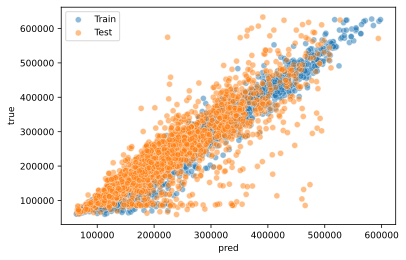

In [52]:
# Оценка результатов с помощью метрики R2
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# **8. Кросс-валидация**

In [53]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72819013, 0.70996783, 0.73869584])

In [54]:
cv_score.mean()

0.7256179331228312

# **9. Важность признаков**

In [55]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.395303
21,MedPriceBySocial,0.297674
22,MedPriceByFloor,0.054345
20,MedPriceByFloorYear,0.037990
2,LifeSquare,0.032332
18,DistrictSize,0.027238
6,HouseYear,0.026598
12,Social_3,0.020816
5,HouseFloor,0.016158
7,Ecology_1,0.013702


Наибольшую важность показали признаки непосредственно связанные с целевой переменной

# **10. Прогнозирование на тестовом датасете**

In [56]:
test_df.shape

(5000, 23)

In [57]:
submit = pd.read_csv(SAMPLE_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [58]:
predictions = rf_model.predict(test_df)
predictions

array([155293.16763242, 118368.50525995, 136380.27483076, ...,
       149040.70486382, 187741.56559448, 242274.7254451 ])

In [59]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,155293.167632
1,5925,118368.505260
2,960,136380.274831
3,3848,112491.076823
4,746,194707.072005


In [60]:
submit.to_csv('rf_submit.csv', index=False)